### Problem Statement

Adventure Works Cycles, a large wholesaler of bicycles in the US and Europe, has noticed that their total profits have been declining over the last few months. They have approached you to help them analyzing what are the drivers of this change.

The company’s IT department has provided you with the company’s sales data over the last few years. In the absence of any consultation with the business, you will need to examine this data on your own and decide which key elements you will focus on in your analysis.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('adventure_works_purchase_orders.csv')

In [3]:
df.head()

,SalesOrderNumber,OrderDate,DueDate,ShipDate,Sales_Person,Sales_Region,Sales_Province,Sales_City,Sales_Postal_Code,Customer_Code,...,LineItem_Id,Product_Category,Product_Sub_Category,Product_Name,Product_Code,Unit_Cost,UnitPrice,UnitPriceDiscount,OrderQty,Unit_Freight_Cost
0,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,1,Bikes,Mountain Bikes,"Mountain-100 Black, 42",BK-M82B-42,1898.0944,3374.99,0.0,1,51.3415
1,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,2,Bikes,Mountain Bikes,"Mountain-100 Black, 44",BK-M82B-44,1898.0944,3374.99,0.0,3,51.3415
2,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,3,Bikes,Mountain Bikes,"Mountain-100 Black, 48",BK-M82B-48,1898.0944,3374.99,0.0,1,51.3415
3,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,4,Bikes,Mountain Bikes,"Mountain-100 Silver, 38",BK-M82S-38,1912.1544,3399.99,0.0,1,51.3415
4,SO43659,7/1/05,00:00.0,00:00.0,Tsvi Reiter,United States,Tennessee,Memphis,38103,AW00029825,...,5,Bikes,Mountain Bikes,"Mountain-100 Silver, 42",BK-M82S-42,1912.1544,3399.99,0.0,1,51.3415


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41884 entries, 0 to 41883
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalesOrderNumber      41884 non-null  object 
 1   OrderDate             41884 non-null  object 
 2   DueDate               41884 non-null  object 
 3   ShipDate              41884 non-null  object 
 4   Sales_Person          41884 non-null  object 
 5   Sales_Region          41884 non-null  object 
 6   Sales_Province        41884 non-null  object 
 7   Sales_City            41884 non-null  object 
 8   Sales_Postal_Code     41884 non-null  int64  
 9   Customer_Code         41884 non-null  object 
 10  Customer_Name         41884 non-null  object 
 11  Customer_Region       41884 non-null  object 
 12  Customer_Province     41884 non-null  object 
 13  Customer_City         41884 non-null  object 
 14  Customer_Postal_Code  41884 non-null  object 
 15  LineItem_Id        

### Data Wrangling
1. Standardizing column names
2. Converting date columns to datetime
3. Adding new calculated features

In [5]:
df = df.rename(columns={'SalesOrderNumber':'Sales_Order_Number',
                  'OrderDate':'Order_Date',
                  'DueDate':'Due_Date',
                  'ShipDate':'Ship_Date',
                  'LineItem_Id':'Line_Item_Id',
                  'UnitPrice':'Unit_Price',
                  'UnitPriceDiscount':'Unit_Price_Discount',
                  'OrderQty':'Order_Qty'})

df.columns = df.columns.str.strip().str.lower()

In [6]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['due_date'] = pd.to_datetime(df['due_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])

##### Calculating Order Cost
order cost = order quantity * (unit cost + unit freight cost)

In [7]:
df['order_cost'] = round(df['order_qty']*(df['unit_cost']+df['unit_freight_cost']),2)

##### Calculating Order Revenue
__If there is no discount:__

Order Revenue = Unit Price * Order Quantity

__If there is a discount:__

Order Revenue = Unit Price * (1 - Unit Discount Percentage) * Order Quantity

In [8]:
def calc_rev(row):
    if row['unit_price_discount'] == 0:
        return row['unit_price']*row['order_qty']
    else:
        return row['unit_price']*(1-row['unit_price_discount'])*row['order_qty']

In [9]:
df['order_revenue']= round(df.apply(lambda row:calc_rev(row),axis=1),2)

##### Calculating Order Profit & Profit per Unit
Order Profit = Order Revenue - Order Cost

Order Profit Per Unit = Order Profit / Order Qty

In [10]:
df['order_profit'] = round(df['order_revenue'] - df['order_cost'],2)

In [11]:
df['order_profit_per_unit'] = round(df['order_profit']/df['order_qty'],2)

## Exploratory Analysis

#### Investigating Total Profit per Quarter

<AxesSubplot:title={'center':'Quarterly Profit'}, xlabel='Order Date', ylabel='Total Profit'>

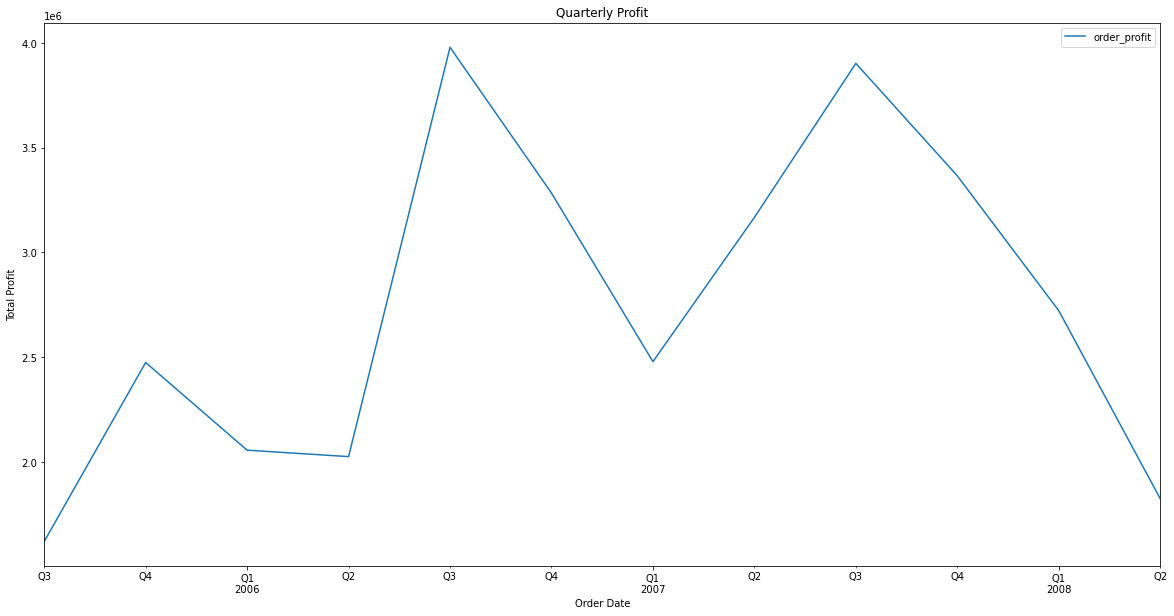

In [12]:
df.groupby(df['order_date'].dt.to_period('Q')).agg({'order_profit':'sum'}).plot(figsize=(20,10),xlabel='Order Date',ylabel='Total Profit',title='Quarterly Profit')

#### What is the main driver of Profit?
Understanding how each product category contributes in total profit

<AxesSubplot:title={'center':'Total Profit per Quarter for each Category'}, xlabel='Order Date', ylabel='Total Profit'>

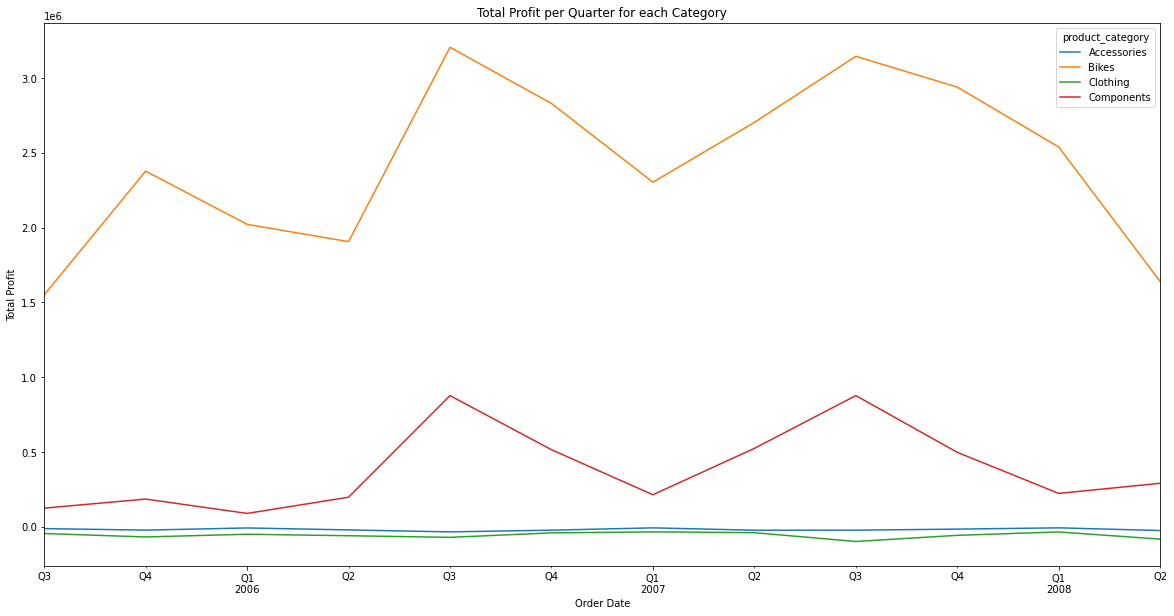

In [13]:
grouped_df = df.groupby([df['order_date'].dt.to_period('Q'),'product_category']).agg({'order_profit':sum}).reset_index()
grouped_df.pivot(index='order_date',columns='product_category',values='order_profit').plot(figsize=(20,10),xlabel='Order Date',ylabel='Total Profit',title='Total Profit per Quarter for each Category')

In [14]:
grouped_df.groupby(grouped_df['product_category']).agg({'order_profit':'sum'}) 

,order_profit
product_category,
Accessories,-211353.12
Bikes,29160717.57
Clothing,-670156.57
Components,4623547.01


<AxesSubplot:title={'center':'Categorical Profit Share Percentage'}, xlabel='Product Category', ylabel='% Profit Share'>

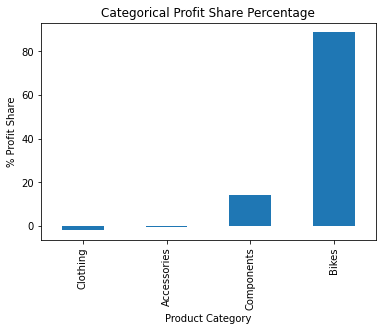

In [15]:
profit_share = grouped_df.groupby(grouped_df['product_category']).agg({'order_profit':sum}) / grouped_df.order_profit.sum() * 100
profit_share = profit_share.sort_values('order_profit')
profit_share.order_profit.plot(kind='bar', xlabel='Product Category', ylabel='% Profit Share', title='Categorical Profit Share Percentage')

#### Extracting Bikes Sales from the Dataset
Since Bikes constitute 88.5% of the total profit, we will continue the investigation on bikes data

In [16]:
df_bikes = df[df['product_category'] == 'Bikes']

#### Investigating Bikes Sales
Looking at total bikes sales, we can see that sales are increasing

<AxesSubplot:title={'center':'Bikes Total Sales per Quarter'}, xlabel='Order Date', ylabel='Order Quantity'>

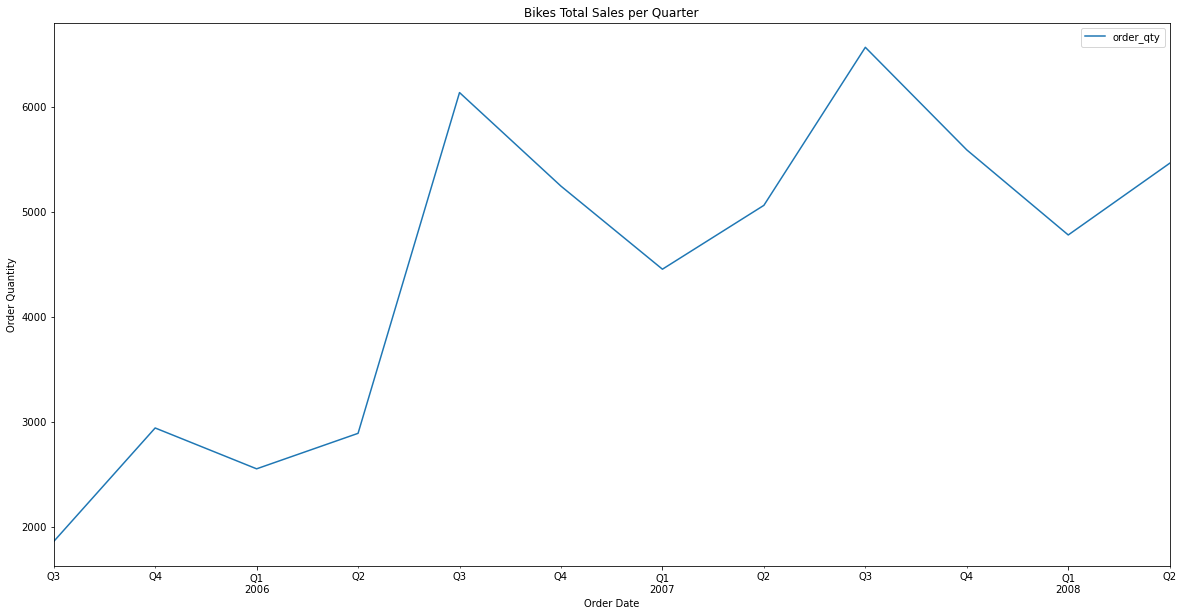

In [17]:
df_bikes.groupby(df_bikes['order_date'].dt.to_period('Q')).agg({'order_qty':'sum'}).plot(figsize=(20,10), xlabel='Order Date', ylabel='Order Quantity', title='Bikes Total Sales per Quarter')

<AxesSubplot:xlabel='order_date'>

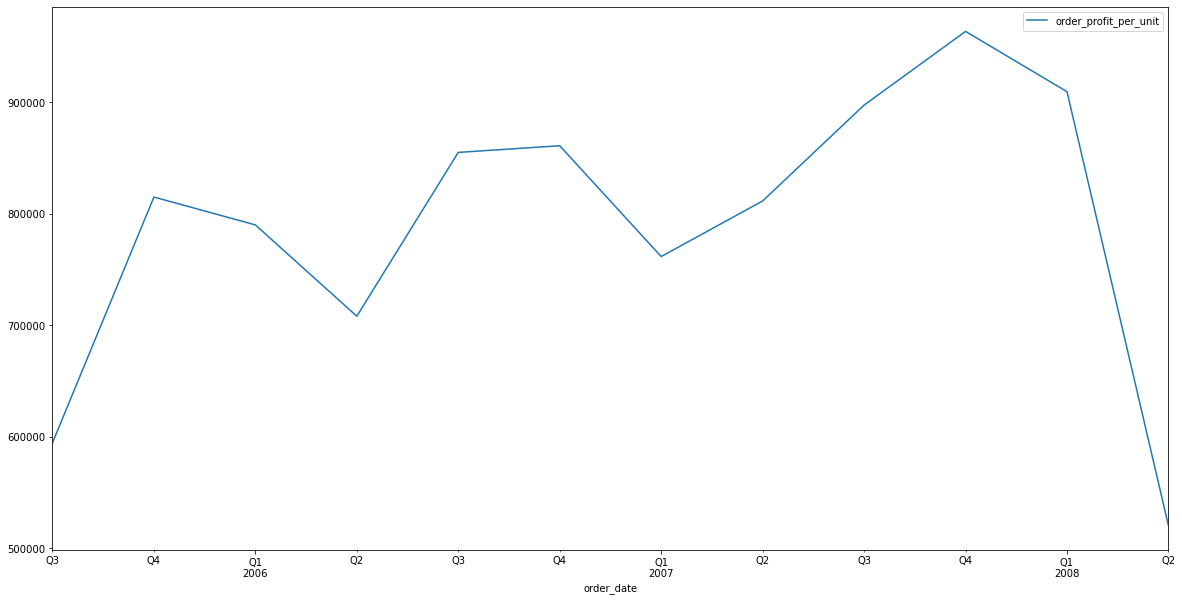

In [18]:
#Order profit per unit is decreasing in the last quarter
df_bikes.groupby(df['order_date'].dt.to_period('Q')).agg({'order_profit_per_unit':sum}).plot(figsize=(20,10))

#### Calculating Net Profit Margin
If profit is decreasing, yet sales is increasing. We need to investigate mean profit margins

/var/folders/mj/ldxq_nvd3xl8rzmnj770svwh0000gn/T/ipykernel_62562/1841830565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikes['net_profit_margin'] = (df_bikes['order_revenue'] - df_bikes['order_cost'])/df_bikes['order_revenue']*100


<AxesSubplot:xlabel='order_date'>

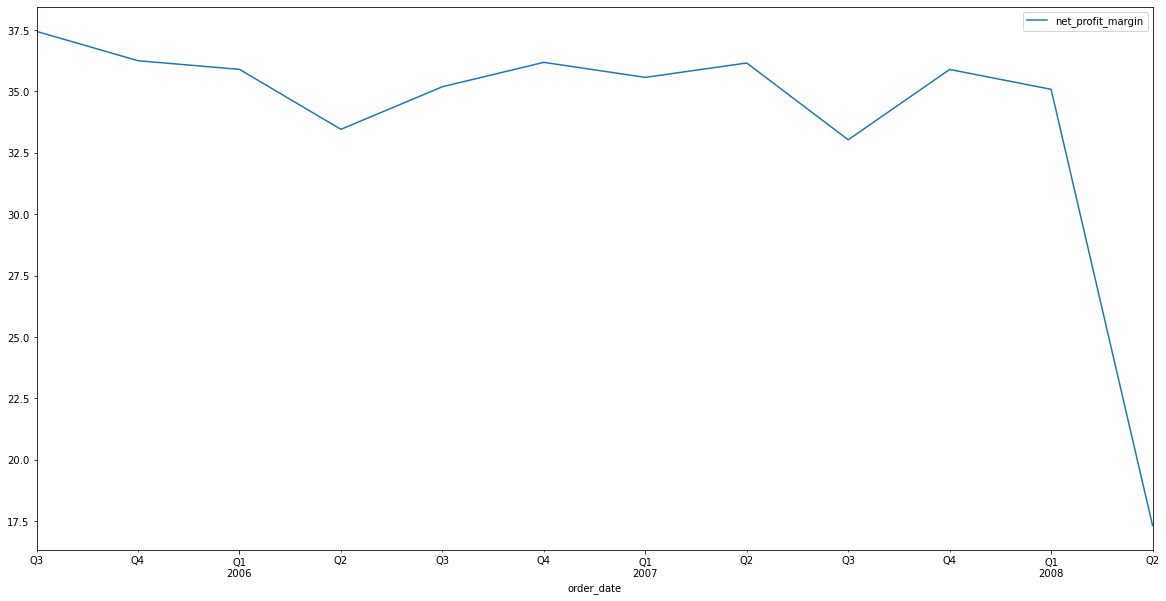

In [19]:
df_bikes['net_profit_margin'] = (df_bikes['order_revenue'] - df_bikes['order_cost'])/df_bikes['order_revenue']*100
df_bikes.groupby(df_bikes['order_date'].dt.to_period('Q')).agg({'net_profit_margin':'mean'}).plot(figsize=(20,10))

#### Investigating Discounts
Double checking if there are any major discounts in the period under investigation

Conclusion: No major discounts that led to lower profit margins

<AxesSubplot:xlabel='order_date'>

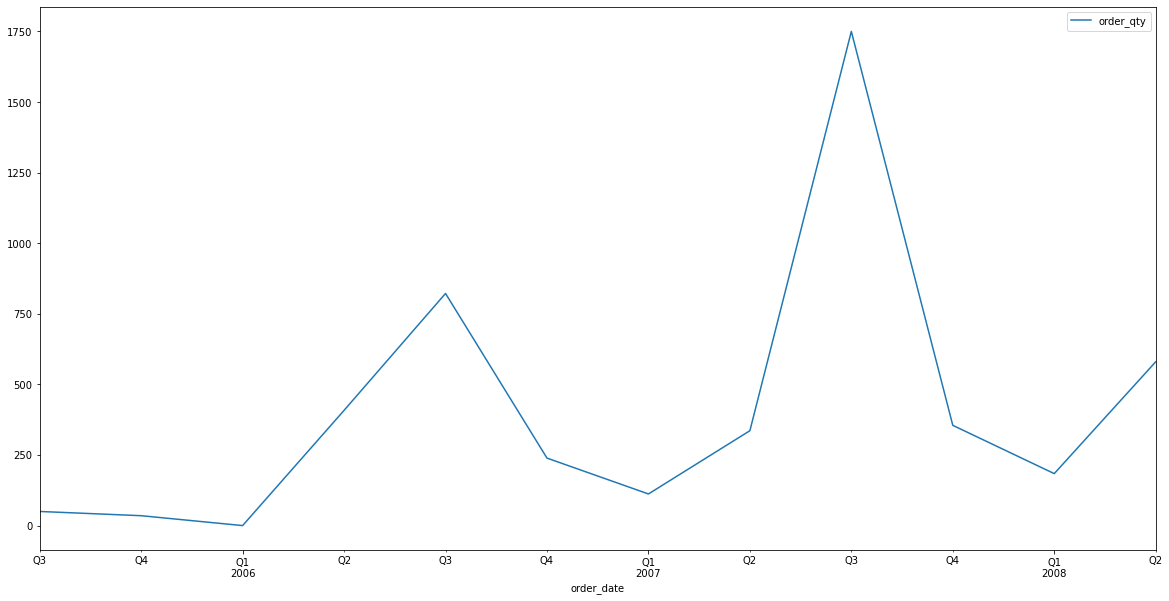

In [20]:
df_bikes.where(df_bikes.unit_price_discount>0).groupby(df['order_date'].dt.to_period('Q')).agg({'order_qty':'sum'}).plot(figsize=(20,10))

#### Investigating Bikes Categories
Investigating order quantities for each bike category

We can see that Touring bikes are introduced in Q3 2007

Conclusion: All 3 bikes categories are following the same pattern

<AxesSubplot:xlabel='order_date'>

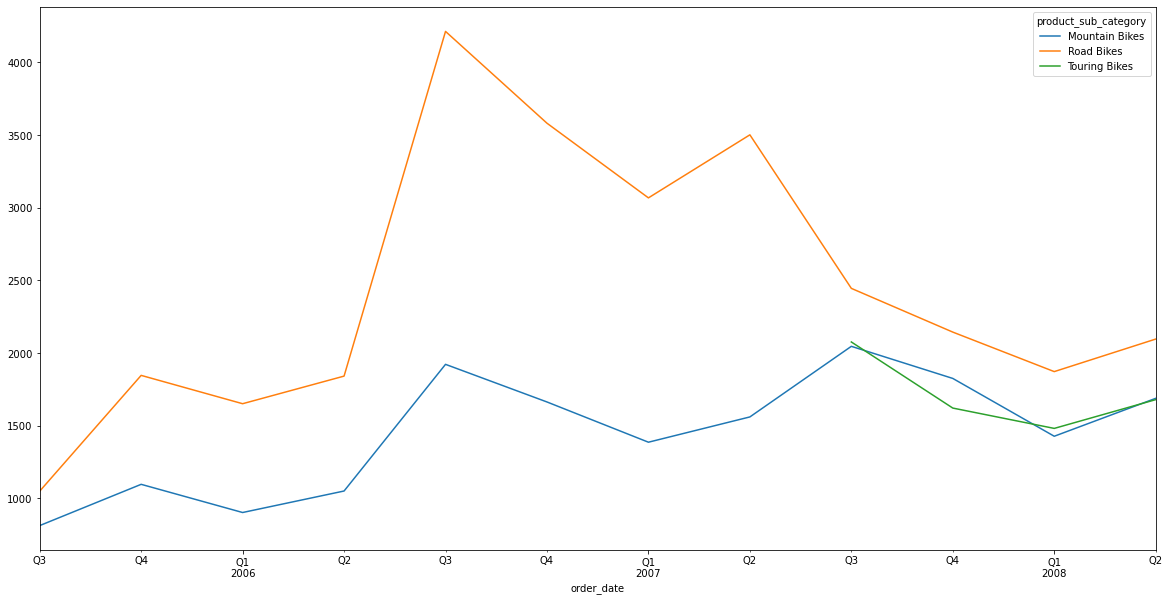

In [21]:
sub_cat_df = df_bikes.groupby([df_bikes['order_date'].dt.to_period('Q'),'product_sub_category']).agg({'order_qty':sum}).reset_index()
sub_cat_df.pivot(index='order_date',columns='product_sub_category',values='order_qty').plot(figsize = (20,10))

<AxesSubplot:xlabel='order_date'>

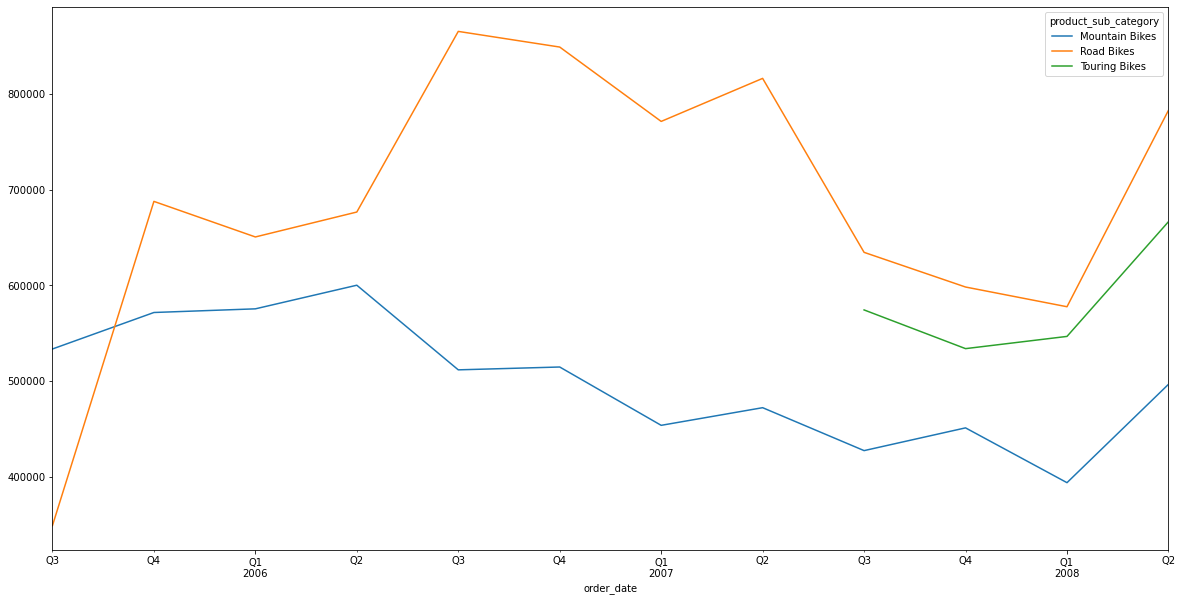

In [22]:
sub_cat_df = df_bikes.groupby([df_bikes['order_date'].dt.to_period('Q'),'product_sub_category']).agg({'unit_cost':'sum'}).reset_index()
sub_cat_df.pivot(index='order_date',columns='product_sub_category',values='unit_cost').plot(figsize = (20,10))

#### Investigating Unit Cost
We can see an increase in mean bike cost during the last quarter

This led to lower profit margins

Which resulted in a decrease in total profit

<AxesSubplot:xlabel='order_date'>

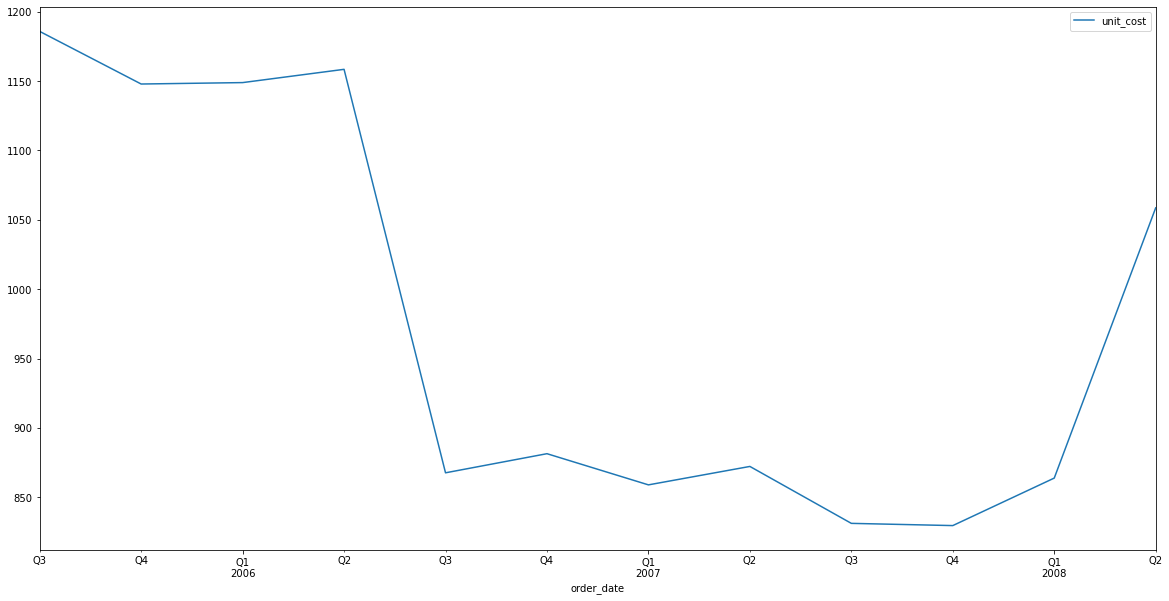

In [23]:
df_bikes.groupby(df['order_date'].dt.to_period('Q')).agg({'unit_cost':'mean'}).plot(figsize=(20,10))

## Conclusion and Recommendation
#### Conclusion:
After investigation we discovered that the main reason behind profit decline in the last quarter is the increase in unit cost without reflecting this increase in consumer prices

#### Recommendation:
* Further analysis is required to better understand the reasons behind the increase in unit cost
* We need to consult with the business on the importance of unprofitable products
* The company needs to adjust consumer prices to mitigate the decrease in net profit margin
* The company should deploy a dashboard to show changes in unit cost